In [1]:
import numpy as np 
import pandas as pd
import os
import random
# import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras import layers
from keras import models
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,  AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='GPU')

seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

import datetime

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1906712550141782512
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1393599694
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8281126508474360996
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


# Import an glimpse the data

In [3]:
# Take all file names in different directory
base_directory     = os.listdir('chest_xray')

train_pne_dir = os.listdir('chest_xray/train/PNEUMONIA/')
train_nor_dir = os.listdir('chest_xray/train/NORMAL/')

val_pne_dir  = os.listdir('chest_xray/val/PNEUMONIA/')
val_nor_dir  = os.listdir('chest_xray/val/NORMAL/')

test_pne_dir = os.listdir('chest_xray/test/PNEUMONIA/')
test_nor_dir = os.listdir('chest_xray/test/NORMAL/')

## Check the size and pixel ranges of pictures


Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1858, 2090)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1152, 1422)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


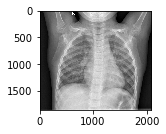

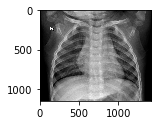

In [4]:
from PIL import Image
# ! pip install imageio
import imageio

for i in range(0,2):
    pic= train_nor_dir[i]
    pic = imageio.imread('chest_xray/train/NORMAL/' + pic)
    plt.figure(figsize = (2,2))
    plt.imshow(pic, cmap='gray')
    print()
    print('Type of the image : ' , type(pic))
    print('Shape of the image : {}'.format(pic.shape))
    print('Dimension of Image {}'.format(pic.ndim))
    print('dtype: ', pic.dtype)
    print('Maximum RGB value in this image {}'.format(pic.max()))
    print('Minimum RGB value in this image {}'.format(pic.min()))

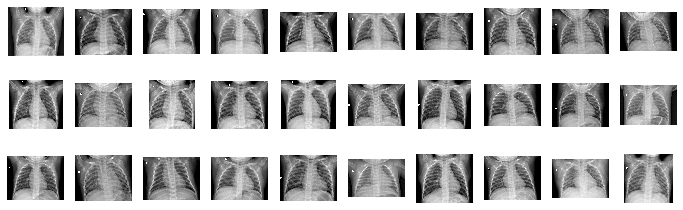

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
n_rows = 3
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        pic= train_nor_dir[index]
        pic = imageio.imread('chest_xray/train/NORMAL/' + pic)
        plt.imshow(pic, cmap='gray')
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('ChestImages')
plt.show()

# Import and preprocessing the data

In [6]:
#https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(37)
tf.random.set_seed(89)
with tf.device('/CPU:0'):
    def data_preprocessing_f(img_dims, batch_size, depth):
        """
        img_dims = target_size of the output image (width, height)
        depth: in this problem, we use 1 : greyscale, or 3: for red green blue scale
        """
        if depth ==1 : 
            color_mode="grayscale" 
        else:
            color_mode="rgb"
        
        train_gen = ImageDataGenerator(rescale=1/255.0, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
    #     val_gen = ImageDataGenerator(rescale=1/255.0)
        test_gen = ImageDataGenerator(rescale=1/255.0)

        train_generator = train_gen.flow_from_directory(
            directory=r"chest_xray/train/",
            target_size=(img_dims, img_dims),
            color_mode = color_mode,
            batch_size=batch_size,
            class_mode="binary",  # sinec we are working witn binary (normal-pernumonia) problem
            shuffle=True,
            subset='training')
    #     
        valid_generator = train_gen.flow_from_directory(
            directory=r"chest_xray/train/",
            target_size=(img_dims, img_dims),
            color_mode = color_mode,
            batch_size=batch_size,
            class_mode="binary",
            shuffle=True, 
            subset='validation')
    #     
        test_generator = test_gen.flow_from_directory(
            directory=r"chest_xray/test/",
            target_size=(img_dims, img_dims),
            color_mode= color_mode,
            batch_size=batch_size,  #need to set this to 1 for test set
            class_mode='binary',  
            shuffle=False)
        return(train_generator, valid_generator, test_generator)


In [7]:
#--------------------------------------------
# Call the function to import the data
img_dims = 150
batch_size = 16
train_generator, valid_generator, test_generator = data_preprocessing_f(img_dims, batch_size, 3)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Frequency of the normal+infected: 
             normal  pnuemonia
train         1073       3100
validation     268        775
test           234        390


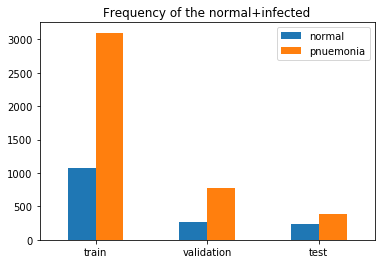

In [8]:
from collections import Counter

# A function to summarize distribution of tran, validation, test sets generated by ImageDataGenerator flow_from_directory
def sum_dat_create_f(train_generator, valid_generator, test_generator):

    train_counter = list(Counter(train_generator.classes).values())
    val_counter   = list(Counter(valid_generator.classes).values())
    test_counter  = list(Counter(test_generator.classes).values())

    summa_dat = pd.DataFrame([train_counter, val_counter, test_counter], columns=('normal', 'pnuemonia'), index = ['train', 'validation', 'test'])
    print('Frequency of the normal+infected: \n', summa_dat)
    summa_dat.plot(kind='bar', title='Frequency of the normal+infected')
    plt.xticks(rotation=0, horizontalalignment="center")
# Call the function
sum_dat_create_f(train_generator, valid_generator, test_generator)

# A basic CNN model

## Creating a basic model using Sequential API

In [9]:
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
# https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/

np.random.seed(35675)
tf.random.set_seed(1352)

model1 = keras.Sequential([
   AveragePooling2D(6,3, input_shape=(img_dims,img_dims, 3)), 
   Conv2D(64, 3, activation='relu'),
   Conv2D(32, 3, activation='relu'),
   MaxPool2D(pool_size=(2,2)),  # so we use max pool to reduce size of image
   Dropout(0.5),    # we can drop out some connection
   Flatten(),
   Dense(128, activation='relu'),  #add another dense layer before doing the output layer
   Dense(1, activation='sigmoid')
])

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 49, 49, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 47, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

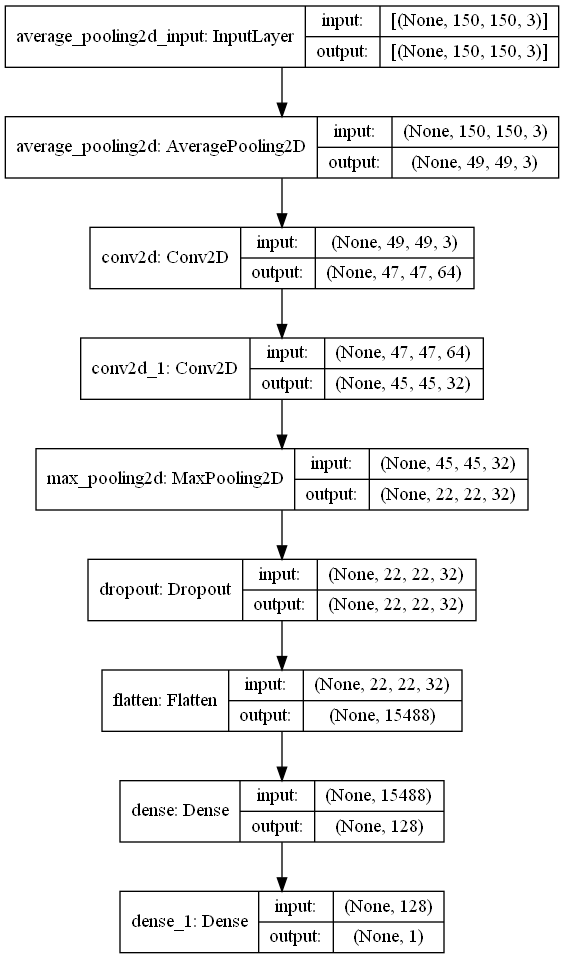

In [11]:
keras.utils.plot_model(model1, "basic_model_1.png", show_shapes=True)

## Compile the model

In [12]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training and Evaluating the Model

In [13]:
epochs = 15
batch_size = 32
model1_hist = model1.fit(x=train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n //batch_size,
                    epochs=epochs,
                    verbose = 1)

Epoch 1/15
130/130 [==============================] - 93s 661ms/step - loss: 0.5757 - accuracy: 0.7475 - val_loss: 0.5407 - val_accuracy: 0.7559
Epoch 2/15
130/130 [==============================] - 84s 650ms/step - loss: 0.4822 - accuracy: 0.7868 - val_loss: 0.4267 - val_accuracy: 0.8105
Epoch 3/15
130/130 [==============================] - 76s 587ms/step - loss: 0.3938 - accuracy: 0.8085 - val_loss: 0.4103 - val_accuracy: 0.8242
Epoch 4/15
130/130 [==============================] - 83s 639ms/step - loss: 0.3211 - accuracy: 0.8606 - val_loss: 0.4177 - val_accuracy: 0.8281
Epoch 5/15
130/130 [==============================] - 89s 682ms/step - loss: 0.3120 - accuracy: 0.8700 - val_loss: 0.3381 - val_accuracy: 0.8730
Epoch 6/15
130/130 [==============================] - 87s 667ms/step - loss: 0.3038 - accuracy: 0.8655 - val_loss: 0.3865 - val_accuracy: 0.8223
Epoch 7/15
130/130 [==============================] - 86s 660ms/step - loss: 0.3054 - accuracy: 0.8699 - val_loss: 0.3118 - val_ac

In [14]:

def draw_hist_f(hist):
    """hist: a history learning curve created by a model.fit where model is a CNN model"""
    
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.title('Learning curve of the model')
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    plt.show()


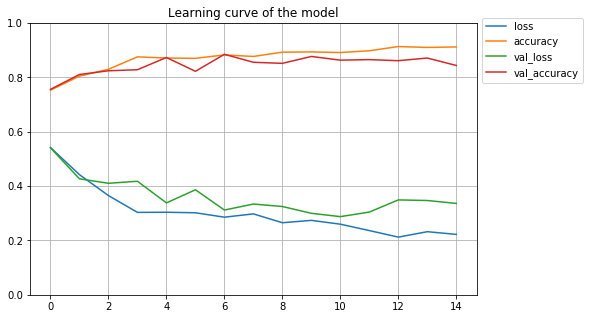

In [15]:
draw_hist_f(model1_hist)

## Evaluate the model in the test set

In [16]:

model1_test_evaluate = model1.evaluate(test_generator, 
                                      steps = test_generator.n//batch_size)
print(model1_test_evaluate)
print("Accuracy = ",model1_test_evaluate[1])

19/19 [==============================] - 9s 476ms/step - loss: 0.5184 - accuracy: 0.7796
[0.5184427499771118, 0.7796052694320679]
Accuracy =  0.7796052694320679


In [17]:
#https://androidkt.com/keras-confusion-matrix-in-tensorboard/
from sklearn.metrics import confusion_matrix

def evaluate_predictions_f(model, generator, threshold):
    """
    model: a cnn 
    generator: test_generator, we will predict and evaluate the accuracy on this
    threshold: in (0,1) a threshold used for cnn with output layer activation=sigmoid
    """
    y_true = generator.classes[generator.index_array]
    y_pred = model.predict(x=generator, batch_size = batch_size)
    y_predClass = np.array(y_pred > threshold,dtype='int32')

    con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_predClass).numpy()
    print('Accuracy: ', np.trace(con_mat)/np.sum(con_mat), '\n')
    #Normalization Confusion Matrix to the interpretation of which class is being misclassified.
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm, index= ['Normal', 'Pneumonia'], columns=['Normal', 'Pneumonia'] )
    return(con_mat_df)
# 


In [18]:
# # Call the function
con_mat1 = evaluate_predictions_f(model1, test_generator, 0.5)
print('Normalized confusion matrix of model 1 \n', con_mat1)

Accuracy:  0.8365384615384616 

Normalized confusion matrix of model 1 
            Normal  Pneumonia
Normal       0.72       0.28
Pneumonia    0.09       0.91


In [19]:
con_mat1 = evaluate_predictions_f(model1, test_generator, 0.8)
print('Normalized confusion matrix of model 1 \n', con_mat1)

Accuracy:  0.7980769230769231 

Normalized confusion matrix of model 1 
            Normal  Pneumonia
Normal       0.88       0.12
Pneumonia    0.25       0.75


# A model with apply callback and some other ways to avoid overfitting (drop-out, )

## Create a model

In [20]:
#%load_ext tensorboard

In [21]:
seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

input_shape = Input(shape=(img_dims, img_dims, 3))

model2 = keras.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=[img_dims, img_dims, 3]),
    BatchNormalization(), # use Batch Normalization to address the vanishing/exploding gradients problems
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(64, 3, activation='relu'),
    Conv2D(32, 3, activation='relu'),
    
    #Note: Instead of using a convolutional layer with a 5 × 5 kernel, 
    # it is generally preferable to stack two layers with 3 × 3 kernels:
    # it will use less parameters and require less computations, and will usually perform better (page447 Hand_on)
    SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPool2D(pool_size=(2, 2)),
    
    #Note: Note that the number of filters grows as we climb up the CNN towards the output layer (64, 128, 256) (page448 Hanh-on)
    SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),   
    
    SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), 
    
    #Note: we must flatten its inputs, since a dense network expects a 1D array of features for each instance
    Flatten(),
    Dense(128, activation='relu'),  #add another dense layer before doing the output layer
    Dropout(rate=0.5),     #NOte: dropout to prvent overfitting
    Dense(units=64, activation='relu'),
    Dropout(rate=0.5),
    Dense(1, activation='sigmoid')
])

## Compile the model

In [22]:

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=4, mode='min')

In [23]:
# path = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

## Training and evaluate on the validation set

In [24]:
epochs=25
model2_hist = model2.fit(
            train_generator, 
            steps_per_epoch=train_generator.samples // batch_size, 
            epochs=epochs, 
            validation_data=valid_generator, 
            validation_steps= valid_generator.samples // batch_size, 
            callbacks=[checkpoint, lr_reduce, early_stop])

Epoch 1/25
130/130 [==============================] - 113s 827ms/step - loss: 0.4518 - accuracy: 0.7836 - val_loss: 0.6159 - val_accuracy: 0.7227
Epoch 2/25
130/130 [==============================] - 131s 1s/step - loss: 0.3416 - accuracy: 0.8508 - val_loss: 0.8507 - val_accuracy: 0.7559
Epoch 3/25
130/130 [==============================] - 146s 1s/step - loss: 0.3281 - accuracy: 0.8416 - val_loss: 0.7299 - val_accuracy: 0.7578
Epoch 4/25
130/130 [==============================] - 63s 481ms/step - loss: 0.2402 - accuracy: 0.9023 - val_loss: 0.5390 - val_accuracy: 0.7402
Epoch 5/25
130/130 [==============================] - 47s 358ms/step - loss: 0.2949 - accuracy: 0.8805 - val_loss: 0.3575 - val_accuracy: 0.7676
Epoch 6/25
130/130 [==============================] - 41s 311ms/step - loss: 0.2555 - accuracy: 0.8940 - val_loss: 0.2962 - val_accuracy: 0.8887

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/25
130/130 [==============================] 

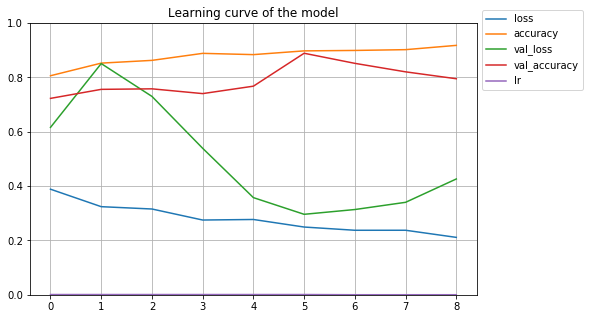

In [25]:
draw_hist_f(model2_hist)

In [26]:
# %tensorboard --logdir logs/fit

## Evaluate on the test set

In [27]:

model2_test_evaluate = model2.evaluate(test_generator, 
                                      steps = test_generator.n//batch_size)
print(model2_test_evaluate)
print("Accuracy = ",model2_test_evaluate[1])

19/19 [==============================] - 4s 191ms/step - loss: 0.2470 - accuracy: 0.9013
[0.24703054130077362, 0.9013158082962036]
Accuracy =  0.9013158082962036


In [28]:
con_mat2 = evaluate_predictions_f(model2, test_generator, 0.5)
print('Normalized confusion matrix of model 2 \n', con_mat2)

Accuracy:  0.7483974358974359 

Normalized confusion matrix of model 2 
            Normal  Pneumonia
Normal       0.96       0.04
Pneumonia    0.38       0.62


# Tuning hyperparameters with callbacks

In [29]:
# Call the tuning function 

#https://keras-team.github.io/keras-tuner/
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf_device='/gpu:0'
from kerastuner.tuners import RandomSearch

seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

with tf.device('GPU:0'):
    # A function to build models with some different options for tuning hyper-parameter
    # This function create multiple options for models with different values for hyper-parametr and compile models
    def build_model_withcallback(hp):
        """hp: stands for hyper-parameters"""
        model = keras.Sequential()

        model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=[img_dims, img_dims, 3]))
        model.add(BatchNormalization()) # use Batch Normalization to address the vanishing/exploding gradients problems
        model.add(MaxPool2D(pool_size=(2, 2)))

        for i in range(hp.Int("Conv Layers", min_value=0, max_value=2)):
            model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [64,128,256]), 3, activation='relu', padding='same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.5))
                
        for i in range(hp.Int("Conv Layers", min_value=0, max_value=2)):
            model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [64,128,256]), 3, activation='relu', padding='same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.5))
        
        # Flatten            
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256]), activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
        return model

    tuner_withcallback = RandomSearch(
        build_model_withcallback,
        objective='val_accuracy',
        max_trials=20,
    )

    tuner_withcallback.search(train_generator, 
                steps_per_epoch=train_generator.samples//batch_size, 
                validation_data=valid_generator,
                epochs=15, 
                batch_size=batch_size, 
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


Trial 20 Complete [00h 33m 39s]
val_accuracy: 0.898370087146759

Best val_accuracy So Far: 0.923298180103302
Total elapsed time: 05h 10m 37s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_model_withcallback = tuner_withcallback.get_best_models()[0]
best_model_withcallback.save('./best_model_withcallback')

INFO:tensorflow:Assets written to: ./best_model_withcallback\assets


In [35]:

best_model_withcallback = keras.models.load_model('./best_model_withcallback')
best_model_evaluate_withcallback = best_model_withcallback.evaluate(test_generator, 
                                      steps = test_generator.n//batch_size)
print(best_model_evaluate_withcallback)

19/19 [==============================] - 8s 406ms/step - loss: 0.5907 - accuracy: 0.8026
[0.5906840562820435, 0.8026315569877625]


In [32]:
test_generator.n
batch_size

32

In [33]:
best_model_withcallback.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 256)       0

In [34]:
con_mat_best_model_withcallback = evaluate_predictions_f(best_model_withcallback, test_generator, 0.5)
print('Normalized confusion matrix of model 2 \n', con_mat_best_model_withcallback)

Accuracy:  0.8830128205128205 

Normalized confusion matrix of model 2 
            Normal  Pneumonia
Normal       0.76       0.24
Pneumonia    0.04       0.96
